In [ ]:
from lle import LLE, WorldState, Action, World
from lle.exceptions import InvalidWorldStateError
import marlenv
import marl
import matplotlib.pyplot as plt
from marl.other.local_graph import LocalGraphTrainer, LocalGraphBottleneckFinder
import numpy as np
import networkx as nx

def state2array(state: WorldState, world: World) -> np.ndarray:
    array = state.as_array()
    array[0] = array[0] / world.height
    array[1] = array[1] / world.width
    return array


def state_hash(state: WorldState, world: World):
    arr_state = state2array(state, world)
    return hash(arr_state.data.tobytes())


In [2]:
env = LLE.from_file("maps/subgraph-1agent.toml").obs_type("layered").single_objective()
world = env.world
# env = LLE.level(6).obs_type("state").single_objective()
masked_actions = np.full((1, 5), True)
masked_actions[0, Action.STAY.value] = False
env = marlenv.Builder(env).mask_actions(masked_actions).build()


qnetwork = marl.nn.model_bank.CNN.from_env(env)
policy = marl.policy.EpsilonGreedy.linear(1.0, 0.05, 100_000)
algo = marl.algo.DQN(qnetwork, policy, marl.policy.ArgMax())
dqn_trainer = marl.training.DQNTrainer(
    qnetwork,
    policy,
    marl.models.TransitionMemory(10_000),
    None,
    gamma=0.95,
    train_interval=(1, "episode"),
)
dqn_trainer = None


finder = LocalGraphBottleneckFinder()
trainer = LocalGraphTrainer(dqn_trainer, finder)


In [ ]:
exp = marl.Experiment.create("logs/test", trainer=trainer, n_steps=1_000_000, test_interval=0, env=env)
exp.run()

Training:   0%|          | 2141/1000000 [00:00<01:07, 14892.21Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:41<00:00, 23990.82Step/s]


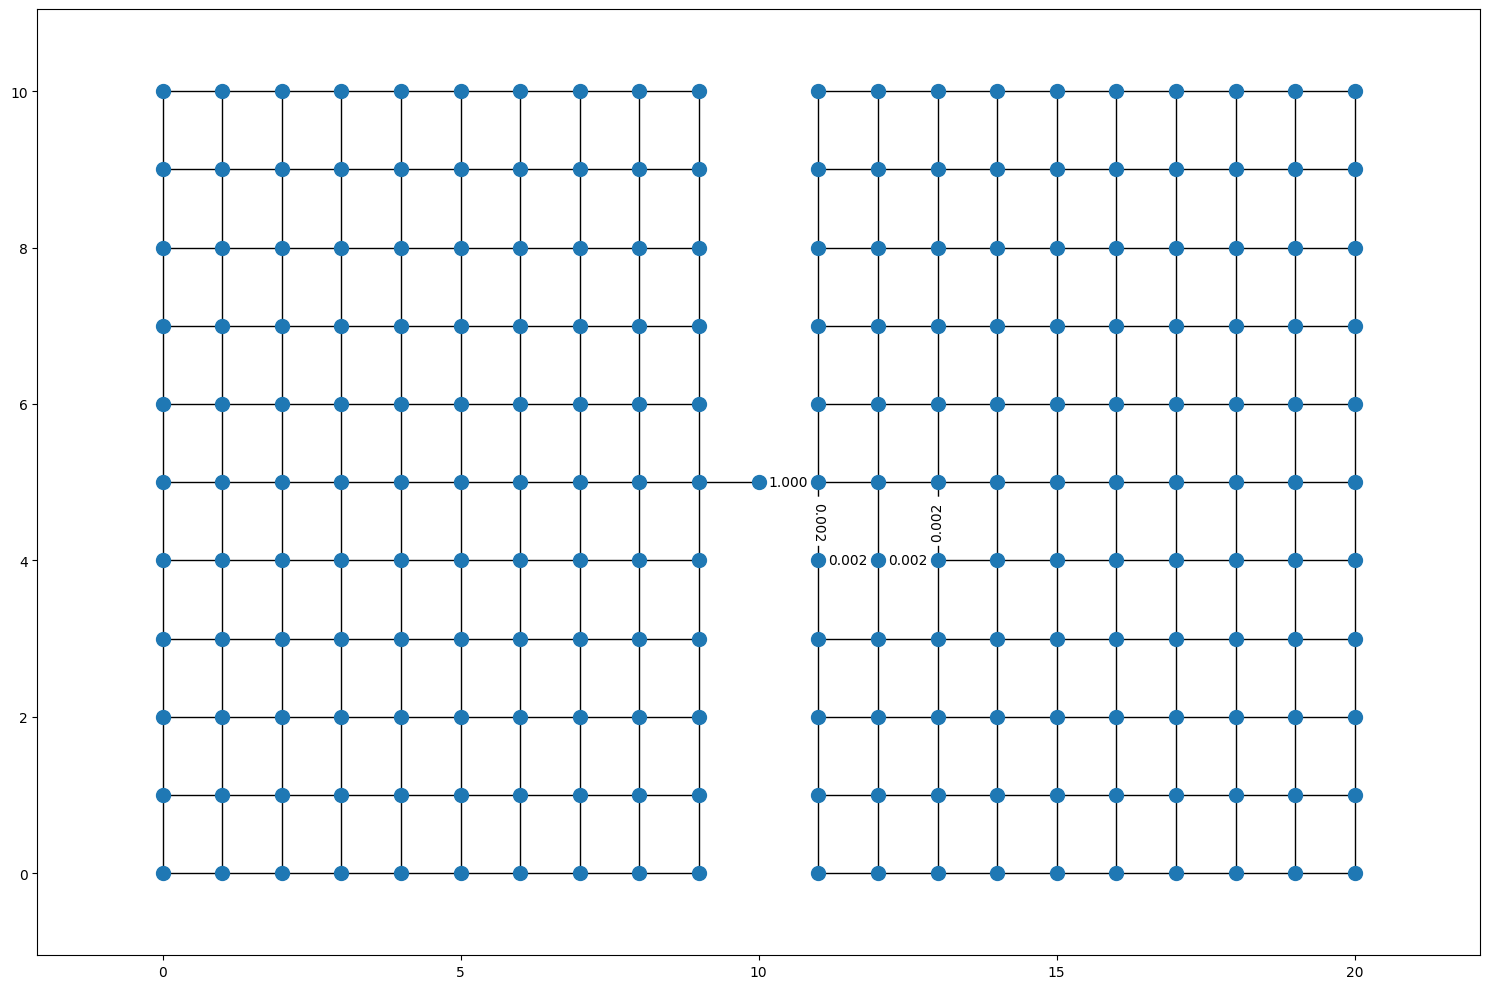

In [43]:
from collections import defaultdict

graph = nx.Graph()
vertex_positions = dict()
edge_predictions = dict()
hit_count = defaultdict(int)
apparition_counts = defaultdict(int)

for i in range(world.height):
    for j in range(world.width):
        from_state = WorldState([(i, j)], [], [True])
        vertex_positions[from_state.agents_positions[0]] = (j, i)
        try:
            world.set_state(from_state)
            for action in world.available_joint_actions():
                if action == [Action.STAY]:
                    continue
                world.set_state(from_state)
                world.step(action)
                new_state = world.get_state()
                edge = (state_hash(from_state, world), state_hash(new_state, world))
                
                graph.add_edge(from_state.agents_positions[0], new_state.agents_positions[0])
                hit_count[i, j] += finder.hit_count.get(edge, 0)
                apparition_counts[i, j] += finder.apparition_count.get(edge, 0)
                bottleneck_probability = finder.predict(edge)
                if bottleneck_probability > 0:
                    edge_predictions[from_state.agents_positions[0], new_state.agents_positions[0]] = f"{bottleneck_probability:.3f}"
        except InvalidWorldStateError:
            pass

node_labels = dict()
for key, hit_count in hit_count.items():
    apparition_count = apparition_counts.get(key, 0)
    node_labels[key] = f"{hit_count}/{apparition_count}"

plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(graph, pos=vertex_positions, label=False, node_size=100)
nx.draw_networkx_edges(graph, pos=vertex_positions)
nx.draw_networkx_edge_labels(graph, pos=vertex_positions, edge_labels=edge_predictions)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.tight_layout()
plt.savefig("bottleneck.svg")
plt.show()